In [1]:
import pandas as pd
# Load the Excel file
df = pd.read_excel('/kaggle/input/predicted-reviews/New_updated_predicted_sentiment_reviews.xlsx')

print(df.head(5))

                          Cleaned Review Description  \
0  video clips could be a bit more relevant to 20...   
1  The text was clear and informative. As I enjoy...   
2  - understanding space analysis, - having a cle...   
3  1) lots of images showing what the text is des...   
4  4. Class 1, 2 & 3 malocclusions organised neat...   

                                      aspect_phrases  \
0   ['video clips', '2020s', 'images illustrations']   
1          ['text', 'appliances', 'chapter', 'book']   
2  ['space analysis', 'reference', 'malocclusion ...   
3                  ['lots images', 'text', 'videos']   
4      ['class malocclusions', 'sections', 'follow']   

                                     opinion_phrases  \
0  ['video clips', 'relevant 2020s succinct', 'im...   
1  ['text', 'clear', 'informative', 'functional a...   
2  ['space analysis', 'clear reference', 'maloccl...   
3                  ['lots images', 'text', 'videos']   
4  ['class malocclusions', 'neatly', 'sections

In [9]:
import ast

# Apply a conversion from string to list using ast.literal_eval to parse the strings as Python lists
df['Sentiment Scores'] = df['Sentiment Scores'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Now let's reapply the transformation to get the max value from each list
df['sentiment'] = df['Sentiment Scores'].apply(lambda x: max(x))

# Display the corrected transformation
df[['Sentiment Scores', 'sentiment']].head()

,Sentiment Scores,sentiment
0,"[0.39076998829841614, 0.6092299818992615]",0.609230
1,"[0.12563839554786682, 0.8743616342544556]",0.874362
2,"[0.33994239568710327, 0.6600576043128967]",0.660058
3,"[0.5321858525276184, 0.46781420707702637]",0.532186
4,"[0.809864342212677, 0.1901356279850006]",0.809864


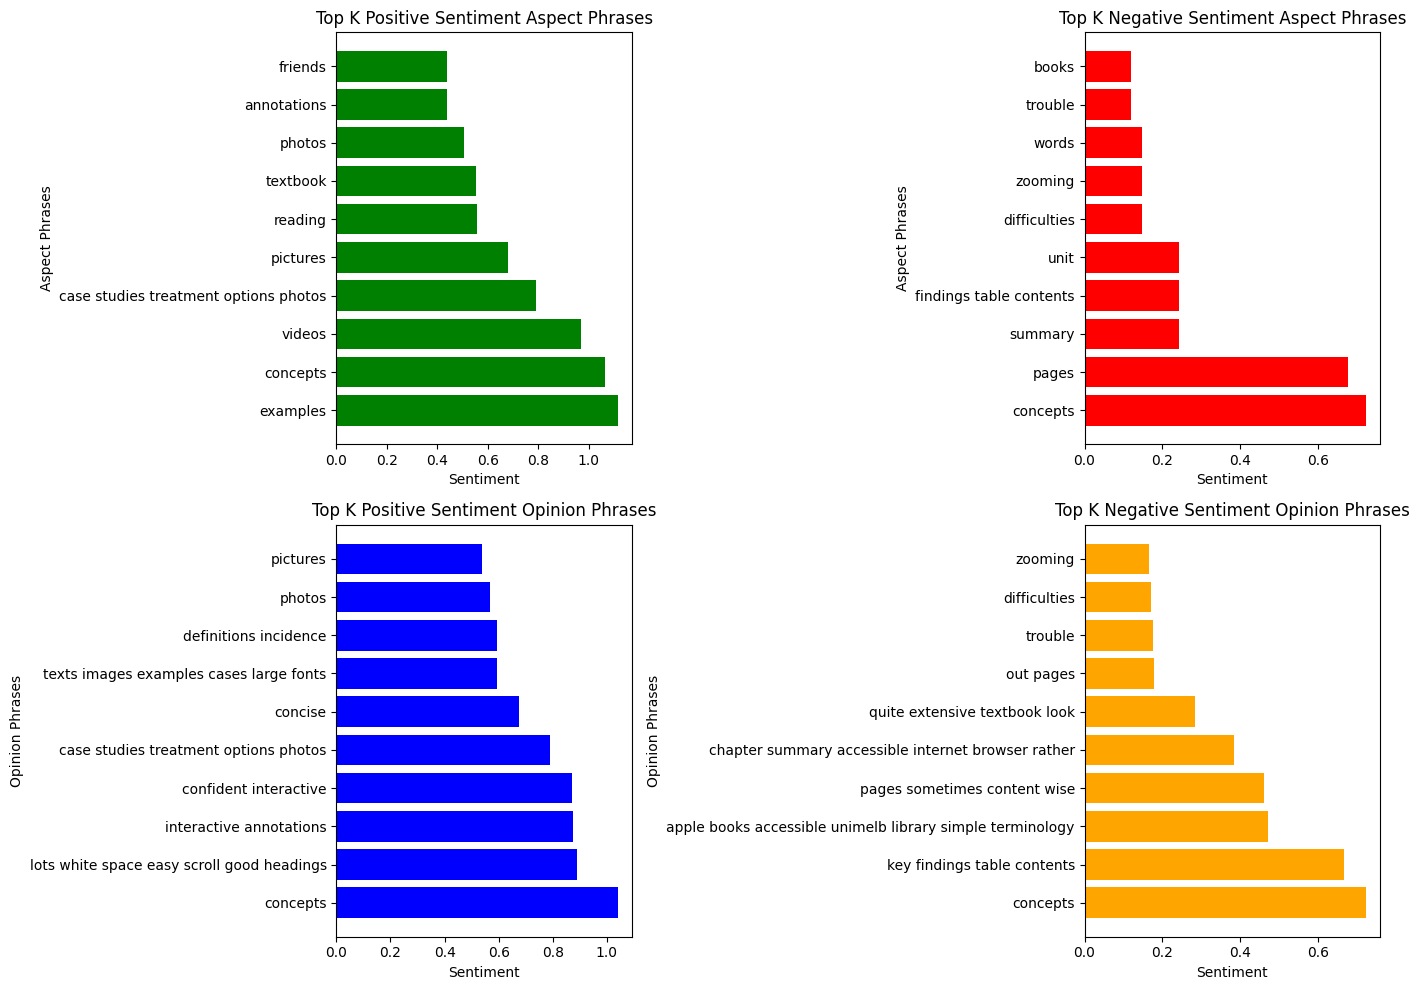

In [12]:
# It seems the matplotlib library might not have been imported properly. Let's re-import it and run the plot again.
import matplotlib.pyplot as plt
from collections import defaultdict

# Helper function to allocate sentiment equally and categorize based on predicted sentiment
def categorize_sentiment_by_label(phrases, sentiment, sentiment_label, positive_dict, negative_dict):
    allocation = sentiment / len(phrases) if phrases else 0
    for phrase in phrases:
        if sentiment_label == 'Positive':  # Positive sentiment
            positive_dict[phrase] += allocation
        else:  # Negative sentiment
            negative_dict[phrase] += allocation

# Resetting the sentiment dictionaries
positive_aspect_sentiments = defaultdict(float)
negative_aspect_sentiments = defaultdict(float)
positive_opinion_sentiments = defaultdict(float)
negative_opinion_sentiments = defaultdict(float)

for idx, row in df.iterrows():
    sentiment_label = row['Predicted Sentiment']
    
    # Categorize aspect phrases into positive or negative based on sentiment label
    aspect_phrases = ast.literal_eval(row['aspect_phrases'])
    categorize_sentiment_by_label(aspect_phrases, row['sentiment'], sentiment_label, positive_aspect_sentiments, negative_aspect_sentiments)

    # Categorize opinion phrases with attention weights into positive or negative based on sentiment label
    opinion_phrases = ast.literal_eval(row['opinion_phrases'])
    attention_weights = ast.literal_eval(row['attention_weights'])
    for phrase, attention in zip(opinion_phrases, attention_weights):
        weighted_sentiment = row['sentiment'] * attention
        categorize_sentiment_by_label([phrase], weighted_sentiment, sentiment_label, positive_opinion_sentiments, negative_opinion_sentiments)

# Get the top K positive and negative aspect and opinion phrases
K = 10
top_k_positive_aspect = sorted(positive_aspect_sentiments.items(), key=lambda x: x[1], reverse=True)[:K]
top_k_negative_aspect = sorted(negative_aspect_sentiments.items(), key=lambda x: x[1], reverse=True)[:K]
top_k_positive_opinion = sorted(positive_opinion_sentiments.items(), key=lambda x: x[1], reverse=True)[:K]
top_k_negative_opinion = sorted(negative_opinion_sentiments.items(), key=lambda x: x[1], reverse=True)[:K]

# Handle cases where there are no negative or positive phrases by setting defaults
aspect_phrases_pos, aspect_values_pos = zip(*top_k_positive_aspect) if top_k_positive_aspect else ([], [])
opinion_phrases_pos, opinion_values_pos = zip(*top_k_positive_opinion) if top_k_positive_opinion else ([], [])
aspect_phrases_neg, aspect_values_neg = zip(*top_k_negative_aspect) if top_k_negative_aspect else ([], [])
opinion_phrases_neg, opinion_values_neg = zip(*top_k_negative_opinion) if top_k_negative_opinion else ([], [])

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot positive and negative aspects
axes[0, 0].barh(aspect_phrases_pos, aspect_values_pos, color='green')
axes[0, 0].set_title('Top K Positive Sentiment Aspect Phrases')
axes[0, 0].set_xlabel('Sentiment')
axes[0, 0].set_ylabel('Aspect Phrases')

axes[0, 1].barh(aspect_phrases_neg, aspect_values_neg, color='red')
axes[0, 1].set_title('Top K Negative Sentiment Aspect Phrases')
axes[0, 1].set_xlabel('Sentiment')
axes[0, 1].set_ylabel('Aspect Phrases')

# Plot positive and negative opinions
axes[1, 0].barh(opinion_phrases_pos, opinion_values_pos, color='blue')
axes[1, 0].set_title('Top K Positive Sentiment Opinion Phrases')
axes[1, 0].set_xlabel('Sentiment')
axes[1, 0].set_ylabel('Opinion Phrases')

axes[1, 1].barh(opinion_phrases_neg, opinion_values_neg, color='orange')
axes[1, 1].set_title('Top K Negative Sentiment Opinion Phrases')
axes[1, 1].set_xlabel('Sentiment')
axes[1, 1].set_ylabel('Opinion Phrases')

plt.tight_layout()
plt.show()